# Decision Analysis - Project 1

### Promethee I and II, SRF, Electre TRI-B

---
**Team members:**

- Sofya Aksenyuk, 150284
- Uladzimir Ivashka, 150281

---

## Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

## Dataset

In [2]:
df = pd.read_csv('Project1_dataset.csv')

In [3]:
df = df.set_index('Alternative')

In [4]:
df

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
Alternative,,,,
a1,98,8,140,400
a2,58,0,123,800
a3,66,5,128,1000
a4,74,3,106,600
a5,80,7,147,200
a6,82,10,118,600
a7,58,1,109,200
a8,73,12,132,800
a9,92,9,121,500


> 1. What is the domain of the problem about? 

Choosing a house based on several criterias (described below).

> 2. What is the source of the data? Were there more of them in the original data set?

The dataset was created from scratch, basing on the described story. Therefore, the data presented is "full" (i.e., no parameters was omitted).

> 3. What is the point of view of the decision maker?

A recently married couple is searching a new place of living as a fresh start of a young family. They are looking for a relatively small house since there's just two of them for now. They find garage area quite important aspect of the place, since they both got cars to commute. They are not that keen on gardening, therefore, they say it would be nice to have some garden, but it's not something necessary.

> 4. What is the number of alternatives considered?

There are **twelve alternatives**, each of them representing a house to buy, e.g.:

> 5. Describe one of the alternatives considered.

- a1 - one-store countryside house of 140 $m^2$ area with the garage of 98 $m^2$ and garden of 8 hectares. All for the cost of 400'000 USD.

> 6. What is the number of criteria considered? 7. What is the origin of the various criteria? 

There are **four criterias** describing a place, taken from a local estate agency website:

- g1 - garage area (in $m^2$) 
- g2 - garden size (in hectares)
- g3 - living area (in $m^2$)
- g4 - cost (in thousands USD)

where, we would like to maximize first three criterias for as less price as possible.

> 9. Are all criteria of equal importance (should they have the same ”weights”)? Are there any criteria among the criteria that are completely or almost invalid / irrelevant?

As it could be noticed, the Decision Maker (i.e., the married couple in our case) stated their preferences on the importance of each criteria. Therefore, the **weights** are different for each of them. Each of them is relevant, but garden area (g2) is of least priority. We have tested two possible set of weights:

- [3, 1, 4, 6]
- [4, 1, 6, 2] 

for criterias [g1, g2, g3, g4] respectively, stating less importance in price in the second set of weights to present some presumably better units to the decision maker, see if they are ready for such a trade-off for these variants.

> 8. What are the domains of the individual criteria (discrete / continuous)? What is the nature (gain / cost) of the individual criteria?

Ranges of each criteria values:

- g1: 58-100 ($m^2$) (gain type)
- g2: 0-10 (hectares) (gain type)
- g3: 105-147 ($m^2$) (gain type)
- g4: 200-1000 (thousands USD) (cost type)

where, all of them are continious.

> 11. What should the theoretically best alternative look like in your opinion? Is it a small advantage on many criteria, or rather a strong advantage on few (but key) criteria?

Theoretically, the best alternative should rather have a strong advantage on **key criterias** (g3, g4, i.e., living are and cost), than small advantage on many criteria, which can be also followed from the initial weight distribution. Meaning that in our opinion, the best house option should be as large in area as possible for as small price as possible.

> 12. Which of the considered alternatives seems to be the best / definitely better than the others? Is it determined by one reason or rather the overall value of the criteria? Does this alternative still have any weaknesses?

Therefore, there are some alternatives that are better than the other ones based on the described key criterias, e.g.:

- a5 - [g1=80, g2=7, g3=147, g4=200]
- a10 - [g1=100, g2=6, g3=146, g4=300]

that outperform in almost all of the criterias (leaving no place for weaknesses), with a5 being even for the lowest price in the range.

> 13. Which of the considered alternatives seems to be the worst / definitely worse than the others? Is it determined by one reason, or rather the overall value of the criteria? Does this alternative still have any strengths?

However, there also are alternatives that are way worse than the other ones, e.g.:

- a11 - [g1=81, g2=3, g3=105, g4=700]
- a12 - [g1=67, g2=5, g3=105, g4=800]
- a3 - [g1=66, g2=5, g3=128, g4=1000]

that are of average parameters (no clear strength over the other options) but for almost maximum price possible.

> 10. Are there dominated alternatives among the considered data set?

These alternatives can be considered strongly dominating/dominated, respectively, due to the mentioned reasons.

### Apriori

Pairwise ranking comparison:

- a8 is preferred to a7 (low g2 value)
- a5 is preferred to a1 (twice lower cost with nearly same rest parameters)
- a7 is preferred to a4 (g1 is lower but  cost is much lower)
- a3 is preferred to a2 (higher cost but much higher g2)

There are **four classes** an alternative can be assigned to:

1. VERY GOOD
2. GOOD
3. AVERAGE
4. BAD

Pairwise classification comparison:

- a11 is BAD
- a4 is AVERAGE
- a6 is GOOD
- a5 is VERY GOOD

In [5]:
def srf(weights, min_dif=1):
    sorted_weights = weights.sort_values()
    ratio = [sorted_weights.iloc[0]]
    for i in range(1, len(sorted_weights)):
        ratio.extend((sorted_weights.iloc[i] - sorted_weights.iloc[i-1] - min_dif) * ['wc'])
        ratio.append(sorted_weights.iloc[i])
    print('Ratio:', ratio)
    r = []
    wg = dict()
    for i in range(len(ratio)):
        if ratio[i] != 'wc':
            wcs = ratio[:i].count('wc')
            r.append(i+1)
            wg[ratio[i]] = 1 + (len(ratio) - 1) * (i) / (len(ratio) - 1)

    norm = {k: v/sum(wg.values()) for k, v in wg.items()}
    norm = [norm[i] for i in weights]
    print('Normalized weights:', norm)
    return norm

# Promethee

In [6]:
def preference_func(crit, crit_type, q, p):
    mat = np.zeros((len(crit), len(crit)))
    
    for idx1, alt1 in enumerate(crit):
        for idx2, alt2 in enumerate(crit):
            if crit_type == 'gain':
                dif = alt1 - alt2
            elif crit_type == 'cost':
                dif = alt2 - alt1
            if dif > p:
                mat[idx1][idx2] = 1
            elif dif <= q:
                mat[idx1][idx2] = 0
            else:
                mat[idx1][idx2] = (dif - q) / (p - q)
            
    return mat

In [7]:
def compr_pref_index(df, pq, weights):
    mats = []
    for idx, criterion in enumerate(df.columns):
        mat = preference_func(df[criterion], criterion[-5:-1], pq[criterion].loc['q'], pq[criterion].loc['p'])
        mats.append(mat * weights[idx])
    mats = np.array(mats)
    return np.sum(mats, axis=0) / sum(weights)

In [41]:
def promethee(df, pq, weights, min_dif=1):
    weights = pd.Series(weights, index=df.columns)
    weights = srf(weights, min_dif)
    
    cpi = compr_pref_index(df, pq, weights)
    
    neg_flow = np.sum(cpi, axis=0)
    pos_flow = np.sum(cpi, axis=1)
    
    cpi = pd.DataFrame(cpi, columns=df.index, index=list(df.index))
    cpi['Φ+'] = pos_flow
    cpi['Φ-'] = neg_flow
    cpi['Φ'] = cpi['Φ+'] - cpi['Φ-']
    display(cpi)
    
    rank_pos = cpi.sort_values('Φ+', ascending=False)['Φ+'].index
    rank_neg = cpi.sort_values('Φ-')['Φ-'].index
    rank_balance = cpi.sort_values('Φ', ascending=False)['Φ'].index
    
    return pd.DataFrame({'based on Φ+': rank_pos, 'based on Φ-': rank_neg, 'based on Φ': rank_balance})

In [9]:
pq = pd.DataFrame({
    'q': [10, 0, 5, 100],
     'p': [20, 2, 10, 300]
})
pq = pq.set_index(df.columns).T

In [10]:
pq

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,10,0,5,100
p,20,2,10,300


In [26]:
pq2 = pd.DataFrame({
    'q': [20, 2, 15, 50],
     'p': [30, 7, 25, 300]
})
pq2 = pq2.set_index(df.columns).T

In [27]:
pq2

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,20,2,15,50
p,30,7,25,300


In [31]:
promethee_result = promethee(df, pq, np.array([3, 1, 4, 6]))
display(promethee_result)

Ratio: [1, 3, 4, 6]
Normalized weights: [0.2, 0.1, 0.3, 0.4]


Alternative,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,Φ+,Φ-,Φ
a1,0.00,1.00,1.00,0.80,0.21,0.62,0.60,0.78,0.30,0.10,0.94,1.00,7.35,0.83,6.52
a2,0.00,0.00,0.20,0.30,0.00,0.00,0.30,0.00,0.00,0.00,0.30,0.30,1.40,6.01,-4.61
a3,0.00,0.10,0.00,0.40,0.00,0.30,0.40,0.00,0.12,0.00,0.40,0.30,2.02,6.15,-4.13
a4,0.00,0.42,0.40,0.00,0.00,0.00,0.22,0.20,0.00,0.00,0.00,0.20,1.44,5.16,-3.72
a5,0.32,1.00,0.88,0.80,0.00,0.70,0.60,0.70,0.70,0.05,0.80,0.86,7.41,0.75,6.66
a6,0.10,0.50,0.62,0.40,0.10,0.00,0.54,0.20,0.05,0.10,0.40,0.70,3.71,3.28,0.43
a7,0.20,0.45,0.40,0.40,0.00,0.40,0.00,0.40,0.40,0.00,0.40,0.40,3.45,4.76,-1.31
a8,0.10,0.44,0.30,0.40,0.10,0.40,0.50,0.00,0.40,0.10,0.40,0.40,3.54,3.76,-0.22
a9,0.05,0.70,0.70,0.56,0.14,0.00,0.60,0.58,0.00,0.10,0.62,1.00,5.05,2.47,2.58
a10,0.06,1.00,0.95,1.00,0.20,0.86,0.60,0.90,0.50,0.00,0.98,0.95,8.00,0.45,7.55


,based on Φ+,based on Φ-,based on Φ
0,a10,a10,a10
1,a5,a5,a5
2,a1,a1,a1
3,a9,a9,a9
4,a6,a6,a6
5,a8,a8,a8
6,a7,a7,a7
7,a3,a4,a4
8,a4,a11,a3
9,a2,a2,a11


In [12]:
promethee_result2 = promethee(df, pq, np.array([4, 1, 6, 2]))
display(promethee_result2)

Ratio: [1, 2, 'wc', 4, 'wc', 6]
Normalized weights: [0.3076923076923077, 0.07692307692307693, 0.46153846153846156, 0.15384615384615385]


Alternative,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,Φ+,Φ-,Φ
a1,0.000000,1.000000,1.000000,0.923077,0.284615,0.723077,0.846154,0.738462,0.461538,0.076923,0.907692,1.000000,7.961538,0.623077,7.338462
a2,0.000000,0.000000,0.076923,0.461538,0.000000,0.000000,0.461538,0.000000,0.000000,0.000000,0.461538,0.461538,1.923077,5.669231,-3.746154
a3,0.000000,0.076923,0.000000,0.538462,0.000000,0.461538,0.538462,0.000000,0.184615,0.000000,0.538462,0.461538,2.800000,4.653846,-1.853846
a4,0.000000,0.338462,0.153846,0.000000,0.000000,0.000000,0.261538,0.076923,0.000000,0.000000,0.000000,0.076923,0.907692,5.707692,-4.800000
a5,0.261538,1.000000,0.815385,0.692308,0.000000,0.615385,0.846154,0.615385,0.615385,0.038462,0.692308,0.784615,6.976923,0.884615,6.092308
a6,0.076923,0.461538,0.415385,0.538462,0.076923,0.000000,0.753846,0.076923,0.038462,0.076923,0.538462,0.769231,3.823077,3.353846,0.469231
a7,0.076923,0.192308,0.153846,0.153846,0.000000,0.153846,0.000000,0.153846,0.153846,0.000000,0.153846,0.153846,1.346154,6.553846,-5.207692
a8,0.076923,0.600000,0.153846,0.538462,0.076923,0.538462,0.692308,0.000000,0.538462,0.076923,0.538462,0.538462,4.369231,3.015385,1.353846
a9,0.038462,0.538462,0.538462,0.784615,0.138462,0.000000,0.846154,0.430769,0.000000,0.076923,0.646154,1.000000,5.038462,2.530769,2.507692
a10,0.092308,1.000000,0.961538,1.000000,0.307692,0.861538,0.846154,0.923077,0.538462,0.000000,0.969231,0.961538,8.461538,0.346154,8.115385


,based on Φ+,based on Φ-,based on Φ
0,a10,a10,a10
1,a1,a1,a1
2,a5,a5,a5
3,a9,a9,a9
4,a8,a8,a8
5,a6,a6,a6
6,a3,a3,a3
7,a2,a11,a2
8,a7,a2,a11
9,a11,a4,a4


In [42]:
promethee_result3 = promethee(df, pq, np.array([25, 10, 41, 52]), 7)
display(promethee_result3)

Ratio: [10, 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 25, 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 41, 'wc', 'wc', 'wc', 'wc', 52]
Normalized weights: [0.17857142857142858, 0.017857142857142856, 0.35714285714285715, 0.44642857142857145]


Alternative,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,Φ+,Φ-,Φ
a1,0.000000,1.000000,1.000000,0.776786,0.151786,0.687500,0.553571,0.839286,0.357143,0.017857,0.946429,1.000000,7.330357,0.705357,6.625000
a2,0.000000,0.000000,0.223214,0.357143,0.000000,0.000000,0.357143,0.000000,0.000000,0.000000,0.357143,0.357143,1.651786,5.491071,-3.839286
a3,0.000000,0.017857,0.000000,0.375000,0.000000,0.357143,0.375000,0.000000,0.142857,0.000000,0.375000,0.357143,2.000000,6.214286,-4.214286
a4,0.000000,0.348214,0.446429,0.000000,0.000000,0.000000,0.125000,0.223214,0.000000,0.000000,0.000000,0.223214,1.366071,5.062500,-3.696429
a5,0.366071,1.000000,0.892857,0.821429,0.000000,0.803571,0.553571,0.803571,0.803571,0.008929,0.821429,0.875000,7.750000,0.419643,7.330357
a6,0.017857,0.419643,0.571429,0.375000,0.017857,0.000000,0.482143,0.223214,0.008929,0.017857,0.375000,0.687500,3.196429,3.616071,-0.419643
a7,0.223214,0.455357,0.446429,0.446429,0.000000,0.446429,0.000000,0.446429,0.446429,0.000000,0.446429,0.446429,3.803571,4.232143,-0.428571
a8,0.017857,0.392857,0.241071,0.375000,0.017857,0.375000,0.464286,0.000000,0.375000,0.017857,0.375000,0.375000,3.026786,4.125000,-1.098214
a9,0.008929,0.642857,0.642857,0.517857,0.053571,0.000000,0.553571,0.607143,0.000000,0.017857,0.616071,1.000000,4.660714,2.714286,1.946429
a10,0.071429,1.000000,0.991071,1.000000,0.178571,0.946429,0.553571,0.982143,0.580357,0.000000,0.982143,0.991071,8.276786,0.080357,8.196429


,based on Φ+,based on Φ-,based on Φ
0,a10,a10,a10
1,a5,a5,a5
2,a1,a1,a1
3,a9,a9,a9
4,a7,a6,a6
5,a6,a8,a7
6,a8,a7,a8
7,a3,a4,a4
8,a2,a11,a2
9,a4,a2,a3


In [29]:
promethee_result2_pq2 = promethee(df, pq2, np.array([4, 1, 6, 2]))
display(promethee_result2)

Ratio: [1, 2, 'wc', 4, 'wc', 6]
Normalized weights: [0.3076923076923077, 0.07692307692307693, 0.46153846153846156, 0.15384615384615385]


Alternative,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,Φ+,Φ-,Φ
a1,0.000000,0.630769,0.476923,0.723077,0.000000,0.415385,0.846154,0.307692,0.215385,0.000000,0.661538,0.938462,5.215385,0.246154,4.969231
a2,0.000000,0.000000,0.092308,0.092308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138462,0.138462,0.461538,3.630769,-3.169231
a3,0.000000,0.046154,0.000000,0.323077,0.000000,0.000000,0.215385,0.000000,0.000000,0.000000,0.369231,0.369231,1.323077,2.800000,-1.476923
a4,0.000000,0.107692,0.153846,0.000000,0.000000,0.000000,0.000000,0.092308,0.000000,0.000000,0.030769,0.092308,0.476923,3.461538,-2.984615
a5,0.092308,0.707692,0.338462,0.646154,0.000000,0.615385,0.584615,0.153846,0.615385,0.030769,0.646154,0.615385,5.046154,0.061538,4.984615
a6,0.000000,0.292308,0.200000,0.076923,0.015385,0.000000,0.200000,0.092308,0.000000,0.030769,0.107692,0.138462,1.153846,1.830769,-0.676923
a7,0.092308,0.153846,0.153846,0.153846,0.000000,0.153846,0.000000,0.153846,0.153846,0.030769,0.153846,0.153846,1.353846,3.615385,-2.261538
a8,0.030769,0.076923,0.169231,0.538462,0.046154,0.000000,0.446154,0.000000,0.015385,0.061538,0.538462,0.538462,2.461538,1.353846,1.107692
a9,0.000000,0.538462,0.369231,0.092308,0.000000,0.030769,0.384615,0.153846,0.000000,0.015385,0.200000,0.384615,2.169231,1.553846,0.615385
a10,0.030769,0.892308,0.600000,0.815385,0.000000,0.615385,0.815385,0.369231,0.553846,0.000000,0.630769,0.923077,6.246154,0.169231,6.076923


,based on Φ+,based on Φ-,based on Φ
0,a10,a10,a10
1,a1,a1,a1
2,a5,a5,a5
3,a9,a9,a9
4,a8,a8,a8
5,a6,a6,a6
6,a3,a3,a3
7,a2,a11,a2
8,a7,a2,a11
9,a11,a4,a4


> 1. Write the preferential information you provided at the input of the method.

The dataset itself, preference and indifference values (p, q), weights are used as input parameters holding preferential information.

> 2. Enter the final result obtained with the method. Usually, the first result is not the final one, you can slightly adjust the parameter values to your preferences.

Initial setting: `[3, 1, 4, 6]` weight set, no change in number of blank cards or thresholds.

1. Results for weights `[3, 1, 4, 6]` (initial setting):

- Promethee I rank Ф+: `['a10', 'a5', 'a1', 'a9', 'a7', 'a6', 'a8', 'a3', 'a4', 'a2', 'a11', 'a12']`
- Promethee I rank Ф-: `['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a2', 'a12', 'a3']`
- Promethee I Partial rank: `['a10', 'a5', 'a1', 'a9', [('a7'), ('a6', 'a8')], [('a4', 'a11', 'a2', 'a12', 'a3'), ('a3', 'a4', 'a2', 'a11', 'a12')]]`
- Promethee II Complete rank: `['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a3', 'a2', 'a12']`

2. Results for weights `[4, 1, 6, 2]` (quality-price trade-off):

- Promethee I rank Ф+: `['a10', 'a1', 'a5', 'a9', 'a8', 'a6', 'a3', 'a2', 'a7', 'a11', 'a4', 'a12']`
- Promethee I rank Ф-: `['a10', 'a1', 'a5', 'a9', 'a8', 'a6', 'a3', 'a11', 'a2', 'a4', 'a12', 'a7']`
- Promethee I Partial rank: `['a10', 'a1', 'a5', 'a9', 'a8', 'a6', 'a3', [('a2', 'a7', 'a11', 'a4', 'a12'), ('a11', 'a2', 'a4', 'a12', 'a7')]]`
- Promethee II Complete rank: `['a10', 'a1', 'a5', 'a9', 'a8', 'a6', 'a3', 'a2', 'a11', 'a4', 'a7', 'a12']`

3. Results for weights `[25, 10, 41, 52]` (leaving same weight preference, adding blank cards):

- Promethee I rank Ф+: `['a10', 'a5', 'a1', 'a9', 'a7', 'a6', 'a8', 'a3', 'a2', 'a4', 'a11', 'a12']`
- Promethee I rank Ф-: `['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a2', 'a3', 'a12']`
- Promethee I Partial rank: `['a10', 'a5', 'a1', 'a9', [('a7'), ('a6', 'a8')], [('a3', 'a2', 'a4', 'a11'), ('a4', 'a11', 'a2', 'a3')], 'a12']`
- Promethee II Complete rank: `['a10', 'a5', 'a1', 'a9', 'a6', 'a7', 'a8', 'a4', 'a2', 'a3', 'a11', 'a12']`

> 4. Comment on the compliance of the results with your expectations and preferences. Refer, among others, to the results for the alternatives that you indicated as the best and worst during the data analysis. What operations were required to obtain the final result?

In our case, changes in p and q thresholds as well as in number of blank cards did not lead to any significant changes (you can see an example of different thresohold asetting above denoted as `pq2`).

Based on the results, the ranking is overall the same for both sets of weights. However, the second weight set paid less attention to cost criteria (as expected), so that, e.g., alternative 'a7' was found as a nearly bad option, which contradicts the actual value of it. Therefore, the initial settings were found more efficient for the stated decision problem, and chosen to be the one for the further comparison of methods' results. Note: third weight set performed almost same as the first one, so technically, there's no big difference in choosing between them.

Alternatives found the best:

- a10
- a5
- a1
- a3

Alternatives found the worst:

- a12
- a2
- a11
- a9

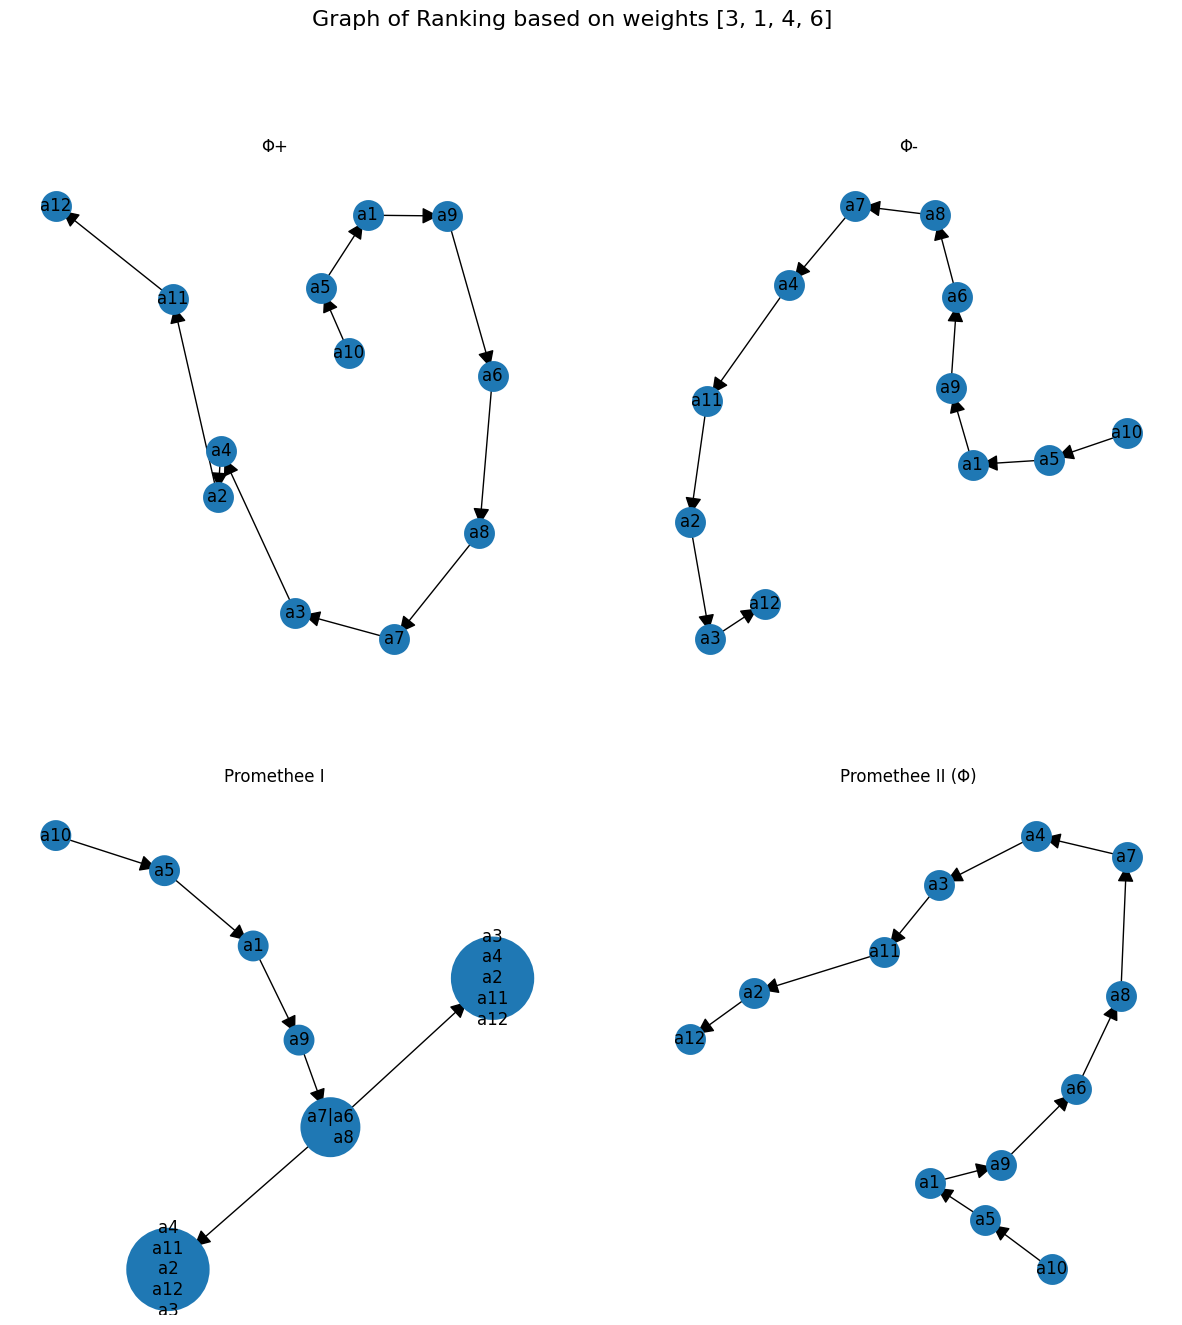

In [91]:
np.random.seed(123456)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

dff = pd.DataFrame({'from': promethee_result['based on Φ+'].values[:-1], 'to': promethee_result['based on Φ+'].values[1:]})
G = nx.from_pandas_edgelist(dff, 'from', 'to', create_using=nx.DiGraph())
nx.draw(G, with_labels=True, node_size=150, alpha=1, linewidths=10, ax=ax[0], arrowsize=25)
ax[0].set_title('Φ+')

dff = pd.DataFrame({'from': promethee_result['based on Φ-'].values[:-1], 'to': promethee_result['based on Φ-'].values[1:]})
G = nx.from_pandas_edgelist(dff, 'from', 'to', create_using=nx.DiGraph())
nx.draw(G, with_labels=True, node_size=150, alpha=1, linewidths=10, ax=ax[1], arrowsize=25)
ax[1].set_title('Φ-')

dff = pd.DataFrame({'from': ['a10', 'a5', 'a1', 'a9', 'a7|a6\n     a8', 'a7|a6\n     a8'], 
                    'to': ['a5', 'a1', 'a9', 'a7|a6\n     a8', 'a3\na4\na2\na11\na12', 'a4\na11\na2\na12\na3']})
G = nx.from_pandas_edgelist(dff, 'from', 'to', create_using=nx.DiGraph())
node_sizes = [150, 150, 150, 150, 1100, 2500, 2500]
nx.draw(G, with_labels=True, node_size=node_sizes, alpha=1, linewidths=10, ax=ax[2], arrowsize=25)
ax[2].set_title('Promethee I')

dff = pd.DataFrame({'from': promethee_result['based on Φ'].values[:-1], 'to': promethee_result['based on Φ'].values[1:]})
G = nx.from_pandas_edgelist(dff, 'from', 'to', create_using=nx.DiGraph())
nx.draw(G, with_labels=True, node_size=150, alpha=1, linewidths=10, ax=ax[3], arrowsize=25)
ax[3].set_title('Promethee II (Φ)')

fig.suptitle('Graph of Ranking based on weights [3, 1, 4, 6]', fontsize=16)
plt.show()

### Result Comparison

> 3. Compare the complete and partial ranking.

As it can be seen on the graphs above, the ranking is basically the same. Both methods have agreed on "the bests" and "the worsts" out of alternatives, and in the correct way, based on the apriori given DM preferences. However, Promethee II provides less ambiguity in ranking, leading to more concrete but less flexible in choice ranks.

# Electre TRI-B

In [14]:
def marg_concord(crit, crit_type, q, p, b, code=None):
    res = []
    if crit_type == 'gain':
        for alt in crit:
            if code:
                dif = b - alt
            else:
                dif = alt - b
            if dif >= -q:
                res.append(1)
            elif dif < -p:
                res.append(0)
            else:
                res.append((p + dif) / (p - q))
    
    elif crit_type == 'cost':
        for alt in crit:
            if code:
                dif = b - alt
            else:
                dif = alt - b
            if dif <= q:
                res.append(1)
            elif dif > p:
                res.append(0)
            else:
                res.append((p - dif) / (p - q))
    
    return pd.Series(res, index=crit.index)

In [15]:
def marg_discord(crit, crit_type, v, p, b, code=None):
    res = []
    if crit_type == 'gain':
        for alt in crit:
            if code:
                dif = b - alt
            else:
                dif = alt - b
            if dif <= -v:
                res.append(1)
            elif dif >= -p:
                res.append(0)
            else:
                res.append((-dif - p) / (v - p))
    
    elif crit_type == 'cost':
        for alt in crit:
            if code:
                dif = b - alt
            else:
                dif = alt - b
            if dif >= v:
                res.append(1)
            elif dif <= p:
                res.append(0)
            else:
                res.append((v - dif) / (v - p))
    
    return pd.Series(res, index=crit.index)

In [16]:
def compr_concord(df, bd, b_pq, weights, code=None):
    C = []
    for idx, crit in enumerate(df.columns):
        C.append(marg_concord(df[crit], crit[-5:-1], b_pq[crit].loc['q'], b_pq[crit].loc['p'], bd[crit], code=code) * weights[idx])
    return np.sum(C, axis=0)

In [17]:
def out_cred(df, bd, b_pq, weights, code=None):
    mat = pd.DataFrame(index=df.index)
    mat['C'] = compr_concord(df, bd, b_pq, weights, code)
    for idx, crit in enumerate(df.columns):
        mat[f'D{idx}'] = marg_discord(df[crit], crit[-5:-1], b_pq[crit].loc['v'], b_pq[crit].loc['p'], bd[crit], code)
    sigmas = []
    for idx, row in mat.iterrows():
        sigma = row['C']
        for d in row.index[1:]:
            if row[d] > row['C']:
                sigma *= (1 - row[d]) / (1 - row['C'])
        sigmas.append(sigma)
    mat['σ'] = sigmas
    return mat

In [18]:
def relations(creds, lam=0.65):
    rels = []
    for i in range(0, len(creds), 2):
        ab = creds[i]
        ba = creds[i+1]
        rel = pd.DataFrame(index=ab.index)
        rel['σ(ab)'] = ab['σ']
        rel['S(ab)'] = np.where(rel['σ(ab)'] >= lam, 'S', 'S^C')
        rel['σ(ba)'] = ba['σ']
        rel['S(ba)'] = np.where(rel['σ(ba)'] >= lam, 'S', 'S^C')
        
        def get_R(x):
            if x['σ(ab)'] >= lam and x['σ(ba)'] < lam: return '>'
            if x['σ(ab)'] < lam and x['σ(ba)'] >= lam: return '<'
            if x['σ(ab)'] >= lam and x['σ(ba)'] >= lam: return '/'
            if x['σ(ab)'] < lam and x['σ(ba)'] < lam: return '?'
        
        rel['R(ab)'] = rel.apply(lambda row: get_R(row), axis=1)
        rels.append(rel)
    return rels

In [43]:
def electre_tri_b(df, boundaries, b_pqs, weights, lam, min_dif=1):
    weights = pd.Series(weights, index=df.columns)
    weights_norm = srf(weights, min_dif)
    
    creds = []
    for idx, (_, b) in enumerate(boundaries.iterrows()):
        creds.append(out_cred(df, b, b_pqs[idx], weights_norm))
        creds.append(out_cred(df, b, b_pqs[idx], weights_norm, code=True))
    rels = relations(creds, lam)
    display(creds)
    
    pref_struct = pd.DataFrame(index=df.index)
    for idx, rel in enumerate(rels):
        pref_struct[f'b{idx}'] = rel['R(ab)']
        
    pref_struct['PES'] = None
    pref_struct['OPT'] = None
    for idx, row in pref_struct.iterrows():
        for col in row.index[::-1]:
            if row[col] in ('>', '/'):
                pref_struct.loc[idx]['PES'] = f'C{int(col.split("b")[-1]) + 1}'
                break
        if pref_struct.loc[idx]['PES'] is None:
            pref_struct.loc[idx]['PES'] = 'C0'
        for col in row.index:
            if row[col] == '<':
                pref_struct.loc[idx]['OPT'] = f'C{int(col.split("b")[-1])}'
                break
        if pref_struct.loc[idx]['OPT'] is None:
            pref_struct.loc[idx]['OPT'] = 'C3'
        
    return pref_struct

In [20]:
boundaries = pd.DataFrame({
    'b1': [65, 2, 110, 400],
    'b2': [75, 6, 125, 600],
    'b3': [90, 9, 140, 750]
})
boundaries = boundaries.T
boundaries.columns = df.columns

In [21]:
boundaries

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
b1,65,2,110,400
b2,75,6,125,600
b3,90,9,140,750


In [22]:
b1_pq = pd.DataFrame({
    'g1 (gain)': [3, 7, 30],
    'g2 (gain)': [0, 2, 6],
    'g3 (gain)': [1, 4, 30],
    'g4 (cost)': [50, 150, 300]
})
b1_pq.index = ['q', 'p', 'v']

b2_pq = pd.DataFrame({
    'g1 (gain)': [3, 6, 32],
    'g2 (gain)': [0, 1, 6],
    'g3 (gain)': [1, 3, 28],
    'g4 (cost)': [40, 120, 300]
})
b2_pq.index = ['q', 'p', 'v']

b3_pq = pd.DataFrame({
    'g1 (gain)': [2, 5, 27],
    'g2 (gain)': [0, 1, 6],
    'g3 (gain)': [1, 4, 30],
    'g4 (cost)': [40, 100, 350]
})
b3_pq.index = ['q', 'p', 'v']

b_pqs = [b1_pq, b2_pq, b3_pq]

### Boundary profiles

In [23]:
display(b1_pq)
display(b2_pq)
display(b3_pq)

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,3,0,1,50
p,7,2,4,150
v,30,6,30,300


,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,3,0,1,40
p,6,1,3,120
v,32,6,28,300


,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,2,0,1,40
p,5,1,4,100
v,27,6,30,350


In [54]:
b1_pq2 = pd.DataFrame({
    'g1 (gain)': [5, 15, 33],
    'g2 (gain)': [0, 2, 6],
    'g3 (gain)': [20, 45, 30],
    'g4 (cost)': [50, 100, 250]
})
b1_pq2.index = ['q', 'p', 'v']

b2_pq2 = pd.DataFrame({
    'g1 (gain)': [8, 20, 32],
    'g2 (gain)': [1, 3, 6],
    'g3 (gain)': [10, 20, 25],
    'g4 (cost)': [45, 200, 300]
})
b2_pq2.index = ['q', 'p', 'v']

b3_pq2 = pd.DataFrame({
    'g1 (gain)': [5, 15, 27],
    'g2 (gain)': [0, 1, 6],
    'g3 (gain)': [25, 50, 30],
    'g4 (cost)': [60, 300, 350]
})
b3_pq2.index = ['q', 'p', 'v']

b_pqs2 = [b1_pq2, b2_pq2, b3_pq2]

In [55]:
display(b1_pq2)
display(b2_pq2)
display(b3_pq2)

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,5,0,20,50
p,15,2,45,100
v,33,6,30,250


,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,8,1,10,45
p,20,3,20,200
v,32,6,25,300


,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
q,5,0,25,60
p,15,1,50,300
v,27,6,30,350


In [87]:
final_res = electre_tri_b(df, boundaries, b_pqs, weights=np.array([3, 1, 4, 6]), lam=0.5)
display(final_res)

Ratio: [1, 'wc', 3, 4, 'wc', 6]
Normalized weights: [0.21428571428571427, 0.07142857142857142, 0.2857142857142857, 0.42857142857142855]


[                    C  D0  D1        D2        D3         σ
 Alternative                                                
 a1           1.000000   0   0  0.000000  0.000000  1.000000
 a2           0.285714   0   0  0.000000  1.000000  0.000000
 a3           0.571429   0   0  0.000000  1.000000  0.000000
 a4           0.285714   0   0  0.000000  0.666667  0.133333
 a5           1.000000   0   0  0.000000  0.000000  1.000000
 a6           0.571429   0   0  0.000000  0.666667  0.444444
 a7           0.750000   0   0  0.000000  0.000000  0.750000
 a8           0.571429   0   0  0.000000  1.000000  0.000000
 a9           0.785714   0   0  0.000000  0.000000  0.785714
 a10          1.000000   0   0  0.000000  0.000000  1.000000
 a11          0.285714   0   0  0.038462  1.000000  0.000000
 a12          0.285714   0   0  0.038462  1.000000  0.000000,
                     C        D0    D1        D2        D3         σ
 Alternative                                                        
 a1    

,b0,b1,b2,PES,OPT
Alternative,,,,,
a1,>,>,>,C3,C3
a2,<,<,<,C0,C0
a3,<,<,<,C0,C0
a4,<,/,?,C2,C0
a5,>,>,>,C3,C3
a6,?,/,?,C2,C3
a7,>,?,?,C1,C3
a8,?,>,<,C2,C2
a9,>,>,/,C3,C3


In [88]:
final_res['PES'] = final_res['PES'].map({'C0': 'BAD', 'C1': 'AVERAGE', 'C2': 'GOOD', 'C3': 'VERY GOOD'})
final_res['OPT'] = final_res['OPT'].map({'C0': 'BAD', 'C1': 'AVERAGE', 'C2': 'GOOD', 'C3': 'VERY GOOD'})

In [25]:
electre_tri_b(df, boundaries, b_pqs, weights=np.array([4, 1, 6, 2]), lam=0.65)

Ratio: [1, 2, 'wc', 4, 'wc', 6]
Normalized weights: [0.3076923076923077, 0.07692307692307693, 0.46153846153846156, 0.15384615384615385]


[                    C  D0  D1        D2        D3         σ
 Alternative                                                
 a1           1.000000   0   0  0.000000  0.000000  1.000000
 a2           0.461538   0   0  0.000000  1.000000  0.000000
 a3           0.846154   0   0  0.000000  1.000000  0.000000
 a4           0.384615   0   0  0.000000  0.666667  0.208333
 a5           1.000000   0   0  0.000000  0.000000  1.000000
 a6           0.846154   0   0  0.000000  0.666667  0.846154
 a7           0.653846   0   0  0.000000  0.000000  0.653846
 a8           0.846154   0   0  0.000000  1.000000  0.000000
 a9           0.923077   0   0  0.000000  0.000000  0.923077
 a10          1.000000   0   0  0.000000  0.000000  1.000000
 a11          0.384615   0   0  0.038462  1.000000  0.000000
 a12          0.384615   0   0  0.038462  1.000000  0.000000,
                     C        D0    D1        D2        D3         σ
 Alternative                                                        
 a1    

,b0,b1,b2,PES,OPT
Alternative,,,,,
a1,>,>,>,C3,C3
a2,?,<,<,C0,C1
a3,?,?,<,C0,C2
a4,<,<,<,C0,C0
a5,>,>,?,C2,C3
a6,>,?,<,C1,C2
a7,/,?,?,C1,C3
a8,?,>,<,C2,C2
a9,>,?,<,C1,C2


In [44]:
electre_tri_b(df, boundaries, b_pqs, weights=np.array([25, 10, 41, 52]), lam=0.65, min_dif=7)

Ratio: [10, 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 25, 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 'wc', 41, 'wc', 'wc', 'wc', 'wc', 52]
Normalized weights: [0.17857142857142858, 0.017857142857142856, 0.35714285714285715, 0.44642857142857145]


[                    C  D0  D1        D2        D3         σ
 Alternative                                                
 a1           1.000000   0   0  0.000000  0.000000  1.000000
 a2           0.357143   0   0  0.000000  1.000000  0.000000
 a3           0.553571   0   0  0.000000  1.000000  0.000000
 a4           0.196429   0   0  0.000000  0.666667  0.081481
 a5           1.000000   0   0  0.000000  0.000000  1.000000
 a6           0.553571   0   0  0.000000  0.666667  0.413333
 a7           0.812500   0   0  0.000000  0.000000  0.812500
 a8           0.553571   0   0  0.000000  1.000000  0.000000
 a9           0.776786   0   0  0.000000  0.000000  0.776786
 a10          1.000000   0   0  0.000000  0.000000  1.000000
 a11          0.196429   0   0  0.038462  1.000000  0.000000
 a12          0.196429   0   0  0.038462  1.000000  0.000000,
                     C        D0    D1        D2        D3         σ
 Alternative                                                        
 a1    

,b0,b1,b2,PES,OPT
Alternative,,,,,
a1,>,>,>,C3,C3
a2,?,<,<,C0,C1
a3,?,?,<,C0,C2
a4,<,<,?,C0,C0
a5,>,>,>,C3,C3
a6,?,<,?,C0,C1
a7,>,?,?,C1,C3
a8,?,?,<,C0,C2
a9,>,?,?,C1,C3


In [56]:
electre_tri_b(df, boundaries, b_pqs2, weights=np.array([3, 1, 4, 6]), lam=0.5)

Ratio: [1, 'wc', 3, 4, 'wc', 6]
Normalized weights: [0.21428571428571427, 0.07142857142857142, 0.2857142857142857, 0.42857142857142855]


[                    C  D0  D1  D2        D3         σ
 Alternative                                          
 a1           1.000000   0   0   0  0.000000  1.000000
 a2           0.457143   0   0   0  1.000000  0.000000
 a3           0.571429   0   0   0  1.000000  0.000000
 a4           0.571429   0   0   0  0.333333  0.571429
 a5           1.000000   0   0   0  0.000000  1.000000
 a6           0.571429   0   0   0  0.333333  0.571429
 a7           0.921429   0   0   0  0.000000  0.921429
 a8           0.571429   0   0   0  1.000000  0.000000
 a9           0.571429   0   0   0  0.000000  0.571429
 a10          1.000000   0   0   0  0.000000  1.000000
 a11          0.571429   0   0   0  1.000000  0.000000
 a12          0.571429   0   0   0  1.000000  0.000000,
                     C        D0    D1  D2        D3         σ
 Alternative                                                  
 a1           0.600000  1.000000  1.00   1  0.000000  0.000000
 a2           1.000000  0.000000  0.00  

,b0,b1,b2,PES,OPT
Alternative,,,,,
a1,>,>,>,C3,C3
a2,<,<,<,C0,C0
a3,<,<,<,C0,C0
a4,/,/,<,C2,C2
a5,>,>,>,C3,C3
a6,>,/,/,C3,C3
a7,/,?,?,C1,C3
a8,?,>,/,C3,C3
a9,>,/,/,C3,C3


**Note:** C0, C1, C2, C3 correspond to BAD, AVERAGE, GOOOD, VERY GOOD classes, respectively.

> 1. Write the preferential information you provided at the input of the method.

The dataset itself, preference, indifference and veto values (p, q, v), weights, boundaries and lambda are used as input parameters holding preferential information.

> 3. Comment on the compliance of the results with your expectations and preferences. Refer, among others, to the results for the alternatives that you indicated as the best and worst during the data analysis. What operations were required to obtain the final result?

Initial setting: `[3, 1, 4, 6]` weight set, no change in number of blank cards or lambda as well as boundaries.

In our case, changes in p, q, v thresholds as well as in number of blank cards did lead to changes (you can see an example of different thresohold asetting above denoted as `b_pqs2`), however, these changes are to the worse assignments, e.g.:

- a8 got classified as VERY GOOD, when it actually is AVERAGE
- a6 got classified as VERY GOOD after new boundaries proposition, as BAD after addition of blank cards, when it actually is GOOD
- a4 was classified as BAD after addition of blank cards or changing lambda, as GOOD after new boundaries proposition, when it actually is AVERAGE. However, the initial setting is also not quite right in this assignment: PES=GOOD, OPT=BAD
- all the methods agreed on a7 being PES=AVERAGE, OPT=VERY GOOD, when it actually is GOOD

Among the examined settings, initial settings won again as the most accurate class assignee, based on the apriori statements. 

> 2. Enter the final result obtained with the method.

Therefore, the final assignment is:

In [89]:
final_res

,b0,b1,b2,PES,OPT
Alternative,,,,,
a1,>,>,>,VERY GOOD,VERY GOOD
a2,<,<,<,BAD,BAD
a3,<,<,<,BAD,BAD
a4,<,/,?,GOOD,BAD
a5,>,>,>,VERY GOOD,VERY GOOD
a6,?,/,?,GOOD,VERY GOOD
a7,>,?,?,AVERAGE,VERY GOOD
a8,?,>,<,GOOD,GOOD
a9,>,>,/,VERY GOOD,VERY GOOD


As it can be seen, apart from the small issues with a4 and a7 alternatives, the assignment is correct based on the apriori given by the DM. Moreover, the result is completely consistent with the outcome of Promethee methods. 

Alternatives found the best:

- a10
- a5
- a1
- a9

Alternatives found the worst:

- a12
- a2
- a11
- a3

> 4. Compare the optimistic and pessimistic class assignments.

As for the difference between Pessimistic and Optimistic class assignments, Pessimistic one produces more correct assignments than Optimistic one, in our case (see the issues with alternatives a4 and a7 listed above).

## Compare method results

All the performed experiments lead to results consistent with the initial expectations as well as the requirments of the Decision Maker. Both - ranking and classification - agreed on partition of the alternatives. The class segmentations are clearly visible on the resulting table of Electre TRI-B, which can be easily comprehended with the graphs provided by Promethee methods.

In general, all methods did their job, and in a correct way. Decision Maker is satisfied 👍